# Начальный шаг

### Импорт данных и библиотек

In [ ]:
import os
import math
import time
import itertools 
import urllib.request
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import xgboost
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
!pip install catboost
from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
SEED=12345
from scipy import stats

In [ ]:
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

### Изучение и анализ данных

Напишем функцию для быстрого изучения первоначальной статистики

In [ ]:
def info_set(data):
      data.info()
      display(data.head(15))
      display(data.describe())
      print('Количество дубликатов:', data.duplicated().sum())
      print(" ")
      print("Пропуски по столбцам:",data.isnull().sum())
      print(" ")
      for column in data.columns:
        print('Уникальные значения столбца', column)
        print(len(data[column].unique()))

**Данные об электродах**

In [ ]:
info_set(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество дубликатов: 0
 
Пропуски по столбцам: key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
 
Уникальные значения столбца key
3214
Уникальные значения столбца Начало нагрева дугой
14875
Уникальные значения столбца Конец нагрева дугой
14876
Уникальные значения столбца Активная мощность
14869
Уникальные значения столбца Реактивная мощность
14866


Напишем функцию для построения графиков распределения

In [ ]:
def grafik(data, parametr, bins=30):
    fig = plt.figure(figsize=(15, 6), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
    ax_main = fig.add_subplot(grid[:-1, :-1]) 
    ax_right = fig.add_subplot(grid[:-1, -1])  
    sns.distplot(data[parametr], ax=ax_main)
    sns.boxplot(data[parametr], ax=ax_right)
    ax_right.grid(axis='y')
    ax_main.set(title='График '+parametr)
    ax_main.axvline(np.mean(data[parametr]),color='g', linestyle='--', label='Среднее')
    ax_main.axvline(np.median(data[parametr]),color='g', linestyle='-', label='Медиана')
    ax_main.legend()
    fig.show()

Построим графики для мощностей

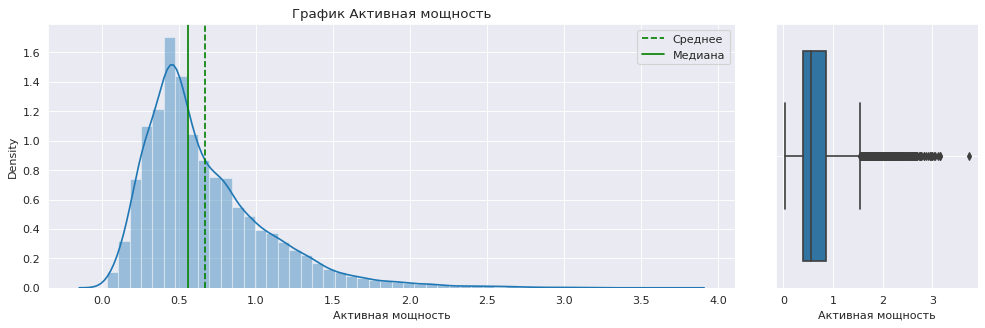

In [ ]:
grafik(data_arc, "Активная мощность")

График распределения партий

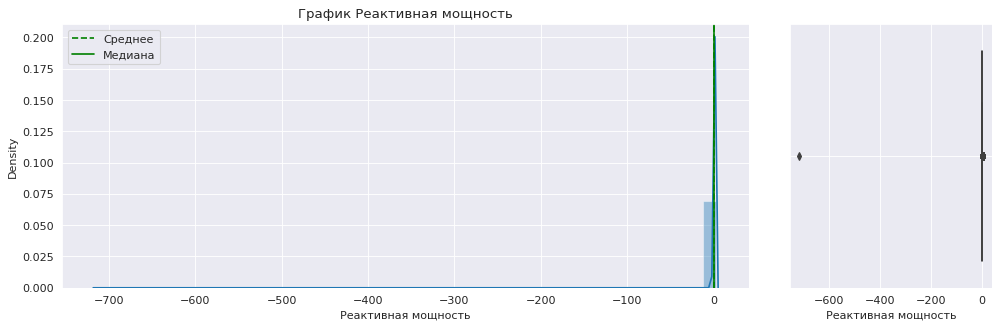

In [ ]:
grafik(data_arc, "Реактивная мощность")

Удалим в столбце Реактивной мощности выпадающие в отрицание за ноль значения.

In [ ]:
data_arc = data_arc[data_arc['Реактивная мощность'] >= 0]

Посмотрим на корреляцию мощностей

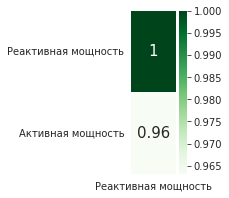

In [ ]:
arc_filtered = data_arc[['Реактивная мощность' ,'Активная мощность']]
plt.figure(figsize=(1,3))
sns.heatmap(arc_filtered.corr()[['Реактивная мощность']], cmap="Greens", annot=True, annot_kws={'size':15})

Чтобы модель не переучивалась, совместим мощности и выделим новый признак, через полную мощность, по формуле:
$$
S = \sqrt{P^2 + Q^2}
$$
где S - полная мощность
P - активная мощность
Q - реактивная мощность

In [ ]:
def s_power(row):
    s_power = math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return s_power

In [ ]:
data_arc['Полная мощность'] = data_arc.apply(s_power, axis=1)

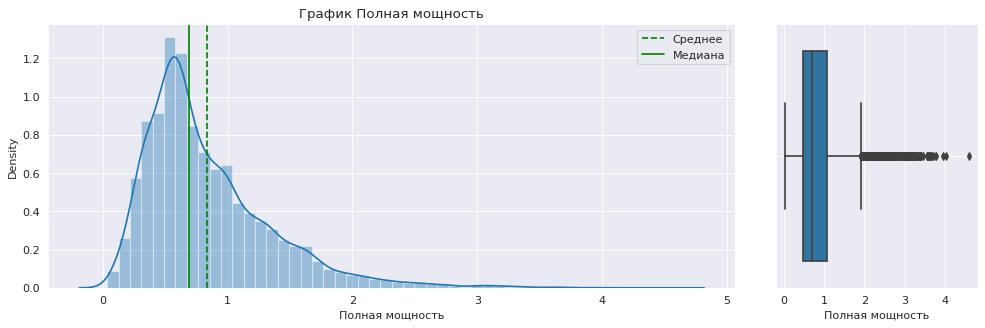

In [ ]:
grafik(data_arc, "Полная мощность")

В столбцах с началом/концом нагрева – изменим тип

In [ ]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])


Датафрейм data_arc содержит 14 876 сессий запуска электродов. Столбцы с временем и концом нагрева, мощностями и уникальным ключом(партии). 

Дубликатов и пропусков нет, уже хорошо.

Заметили для значения Реактивной мощности похожее на ошибку ввода число -715 и убрали их из столбца.

Чтобы адекватно работать со столбцами времени – изменили там тип данных.

Добавили новый признак – Полная мощность.


**Данные о подаче сыпучих материалов (объём)**

In [ ]:
info_set(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество дубликатов: 0
 
Пропуски по столбцам: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
 
Уникальные значения столбца key
3129
Уникальные значения столбца Bulk 1
48
Уникальные значения столбца Bulk 2
16
Уникальные значения столбца Bulk 3
279
Уникальные значения столбца Bulk 4
207
Уникальные значения столбца Bulk 5
56
Уникальные значения столбца Bulk 6
206
Уникальные значения столбца Bulk 7
26
Уникальные значения столбца Bulk 8
2
Уникальные значения столбца Bulk 9
11
Уникальные значения столбца Bulk 10
78
Уникальные значения столбца Bulk 11
102
Уникальные значения столбца Bulk 12
332
Уникальные значения столбца Bulk 13
15
Уникальные значения столбца Bulk 14
285
Уникальные значения столбца Bulk 15
157


Датафрейм data_bulk содержит 3 129 сессий подач сырья. Так как для каждой партии своя рецептура – в некоторых столбцах значения отсутствуют и это нормально.
В минимальных значениях нет отрицательных. Стоит нужный тип данных для каждого столбца.


**Данные о подаче сыпучих материалов (время)**

In [ ]:
info_set(data_bulk_time)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество дубликатов: 0
 
Пропуски по столбцам: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
 
Уникальные значения столбца key
3129
Уникальные значения столбца Bulk 1
253
Уникальные значения столбца Bulk 2
23
Уникальные значения столбца Bulk 3
1299
Уникальные значения столбца Bulk 4
1015
Уникальные значения столбца Bulk 5
78
Уникальные значения столбца Bulk 6
577
Уникальные значения столбца Bulk 7
26
Уникальные значения столбца Bulk 8
2
Уникальные значения столбца Bulk 9
20
Уникальные значения столбца Bulk 10
177
Уникальные значения столбца Bulk 11
178
Уникальные значения столбца Bulk 12
2451
Уникальные значения столбца Bulk 13
19
Уникальные значения столбца Bulk 14
2807
Уникальные значения столбца Bulk 15
2249


Датафрейм data_bulk_time содержит 3 129 строк с временными отрезками, которые мы не будем приводить к нужному типу, так как далее использовать не будем. Так же заметим наличие пропущенных значений

**Данные о продувке сплава газом**

In [ ]:
info_set(data_gas)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество дубликатов: 0
 
Пропуски по столбцам: key      0
Газ 1    0
dtype: int64
 
Уникальные значения столбца key
3239
Уникальные значения столбца Газ 1
3239


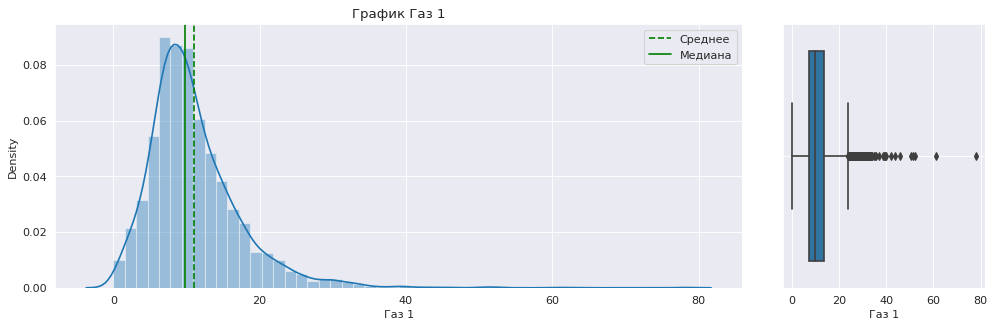

In [ ]:
grafik(data_gas, 'Газ 1')

Датафрейм data_gas содержит 3 238 строк и один столбец с данными о подаче газа. 
Дубликатов и пропущенных значений нет. Cтатистика и распределение выглядят адекватно.

**Результаты измерения температуры**

In [ ]:
info_set(data_temp)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество дубликатов: 0
 
Пропуски по столбцам: key                0
Время замера       0
Температура     2901
dtype: int64
 
Уникальные значения столбца key
3216
Уникальные значения столбца Время замера
15907
Уникальные значения столбца Температура
176


In [ ]:
#grafik(data_temp, 'Температура')
fig = px.histogram(data_temp, x = "Температура", marginal = 'box', title = 'Распределение Температыры')
fig.show()

Изменим тип данных в столбце со временем

In [ ]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

Датафрейм data_temp содержит 3 15 907 строк и столбцы с данными времени замера и температуре.

Дубликатов не было найдено.

В датасете отсутствуют некоторые данные по температурам, их стоит удалить

Распределение нормально, правда, не без небольшого числа выбросов.

Изменили тип данных у времени.

**Данные о проволочных материалах (объём)**

In [ ]:
info_set(data_wire)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество дубликатов: 0
 
Пропуски по столбцам: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
 
Уникальные значения столбца key
3081
Уникальные значения столбца Wire 1
2270
Уникальные значения столбца Wire 2
714
Уникальные значения столбца Wire 3
57
Уникальные значения столбца Wire 4
15
Уникальные значения столбца Wire 5
2
Уникальные значения столбца Wire 6
71
Уникальные значения столбца Wire 7
11
Уникальные значения столбца Wire 8
14
Уникальные значения столбца Wire 9
26



Датафрейм data_wire содержит 3080 строк и столбцы с данными об объёме материалов.
Типы данных указаны верно.

Дубликатов не найжено.

Присутствуют пропущенные значения, которые могли возникнуть из-за различий порций материалов в подаче за разные промежутки времени.




**Данные о проволочных материалах (время)**

In [ ]:
info_set(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество дубликатов: 0
 
Пропуски по столбцам: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
 
Уникальные значения столбца key
3081
Уникальные значения столбца Wire 1
3056
Уникальные значения столбца Wire 2
1080
Уникальные значения столбца Wire 3
64
Уникальные значения столбца Wire 4
15
Уникальные значения столбца Wire 5
2
Уникальные значения столбца Wire 6
74
Уникальные значения столбца Wire 7
12
Уникальные значения столбца Wire 8
20
Уникальные значения столбца Wire 9
30


Датафрейм data_wire_time содержит 3080 строк и столбцы с данными о времени подачи материалов.

Дубликатов не имеется

Имеются пустые значения

С данным датасетом мы тоже не будем работать в дальнейщем поэтому опустим его предобработку

### Вывод по начальному

В датасете data_arc добавили новый признак – Полная мощность.
Перевели нужные столбцы со временем в дэйттайм.

В датасетах были замечены пропуски (в таблицах data_bulk и data_wire указаны 15 и 9 столбцов о различных материалах). Потенциально это может связываться с тем, что в каждую партию идёт определенный набор материалов.

В таблицах разное количество уникальных номеров партии key. Данные по ним утеряны.

Таблицы data_temp и data_arc имеют записи одинаковых значений key в разное времяпсовершения операции. Количество записей у одной партии для каждой таблицы может различаться.

В столбце целевой температуры есть отсутствующие значения, на этапе предобработки мы ужалим их.

Далее предобработаем данные и сгруппируем по признаку key в единую таблицу. 

# Шаг предобработки и подготовки

Решим вопросы:
- Обработки пропусков и удаления пустот в целевой (Финальная температура – там где её нет и где в принципе только один замер)
- Сбора данных в итоговый датасет
- Разделения данных на тренировочную и тестовую


Срежем строки в датафреймах по ключам, которые находятся после партии 2500

In [ ]:
data_bulk = data_bulk.query('key < 2500')
data_wire = data_wire.query('key < 2500')
data_temp = data_temp.query('key < 2500')
data_arc = data_arc.query('key < 2500')

Посчитаем количество итераций нагрева

In [ ]:
data_arc_group = data_arc.groupby(by = 'key', as_index = False).count()[['key', 'Начало нагрева дугой']]
data_arc_group.columns = ['key', 'Количество итераций нагрева']

Сгруппируем данные по партиям

In [ ]:
data_arc = data_arc.groupby(by = 'key', as_index = False).sum()

Добавим итерации к сгруппированным данным

In [ ]:
data_arc = data_arc.merge(data_arc_group, how = 'left', on = 'key')

Из-за риска переобучения, оставим из трёх мощностей только полную

In [ ]:
data_arc = data_arc[['key', 'Полная мощность', 'Количество итераций нагрева']]

Посмотрим на корреляцию на текущем этапе

<Figure size 1080x720 with 0 Axes>

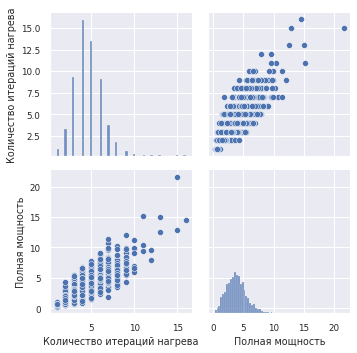

In [ ]:
plt.figure(figsize=(15,10))
sns.set(font_scale=0.8)
sns.pairplot(data_arc[['Количество итераций нагрева','Полная мощность']], 
             kind="scatter")
plt.show();

In [ ]:
data_arc[['Полная мощность', 'Количество итераций нагрева']].corr()

,Полная мощность,Количество итераций нагрева
Полная мощность,1.000000,0.760402
Количество итераций нагрева,0.760402,1.000000


Избавимся от пропусков в датафрейме о температуре

In [ ]:
data_temp = data_temp.dropna(subset=['Температура']).reset_index(drop=True)
data_temp = data_temp.sort_values(by=['Время замера'])

Удалим партии где в строках есть только одно измерение температуры.

In [ ]:
count = data_temp.groupby(by = 'key', as_index = False).count()
one = count[count['Время замера'] == 1]['key'].tolist()
data_temp = data_temp.query('key not in @one')

In [ ]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


Группировка данных по партии

In [ ]:
data_temp = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
data_temp.columns = data_temp.columns.droplevel()
data_temp.columns = ['key', 'Время замера 1', 'Время замера 2', 'Температура 1', 'Температура 2']
data_temp = data_temp[['key', 'Температура 1', 'Температура 2']]

Объединим данные в одну таблицу

In [ ]:
data = (data_temp.merge(data_arc, how = 'left', on = 'key')
                 .merge(data_wire, how = 'left', on = 'key')
                 .merge(data_bulk, how = 'left', on = 'key')
                 .merge(data_gas, how = 'left', on = 'key')
       )








Переименуем столбцы для корректной работы модели

In [ ]:
data = data.rename(columns={'Температура 1': 'First_temp',
                            'Температура 2': 'Last_temp',
                            'Полная мощность': 'Full_power',
                            'Количество итераций нагрева':'Heating_iterations',
                            'Газ 1': 'Gas'})

In [ ]:
data.head(3)

,key,First_temp,Last_temp,Full_power,Heating_iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Gas
0,1,1571.0,1613.0,5.826395,5,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,29.749986
1,2,1581.0,1602.0,3.649216,4,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,12.555561
2,3,1596.0,1599.0,2.989534,5,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,28.554793


Заполним пропуски нулями

In [ ]:
data = data.fillna(0)

Уберём поле с идентификатором партии

In [ ]:
data = data.drop(['key'], axis = 1)

Уберём поле без значений Wire 5

In [ ]:
data = data.drop(['Wire 5'], axis = 1)

Выполним оценку мультиколлинеарности и отсутсвие зависимостей между целевым признаком и остальными

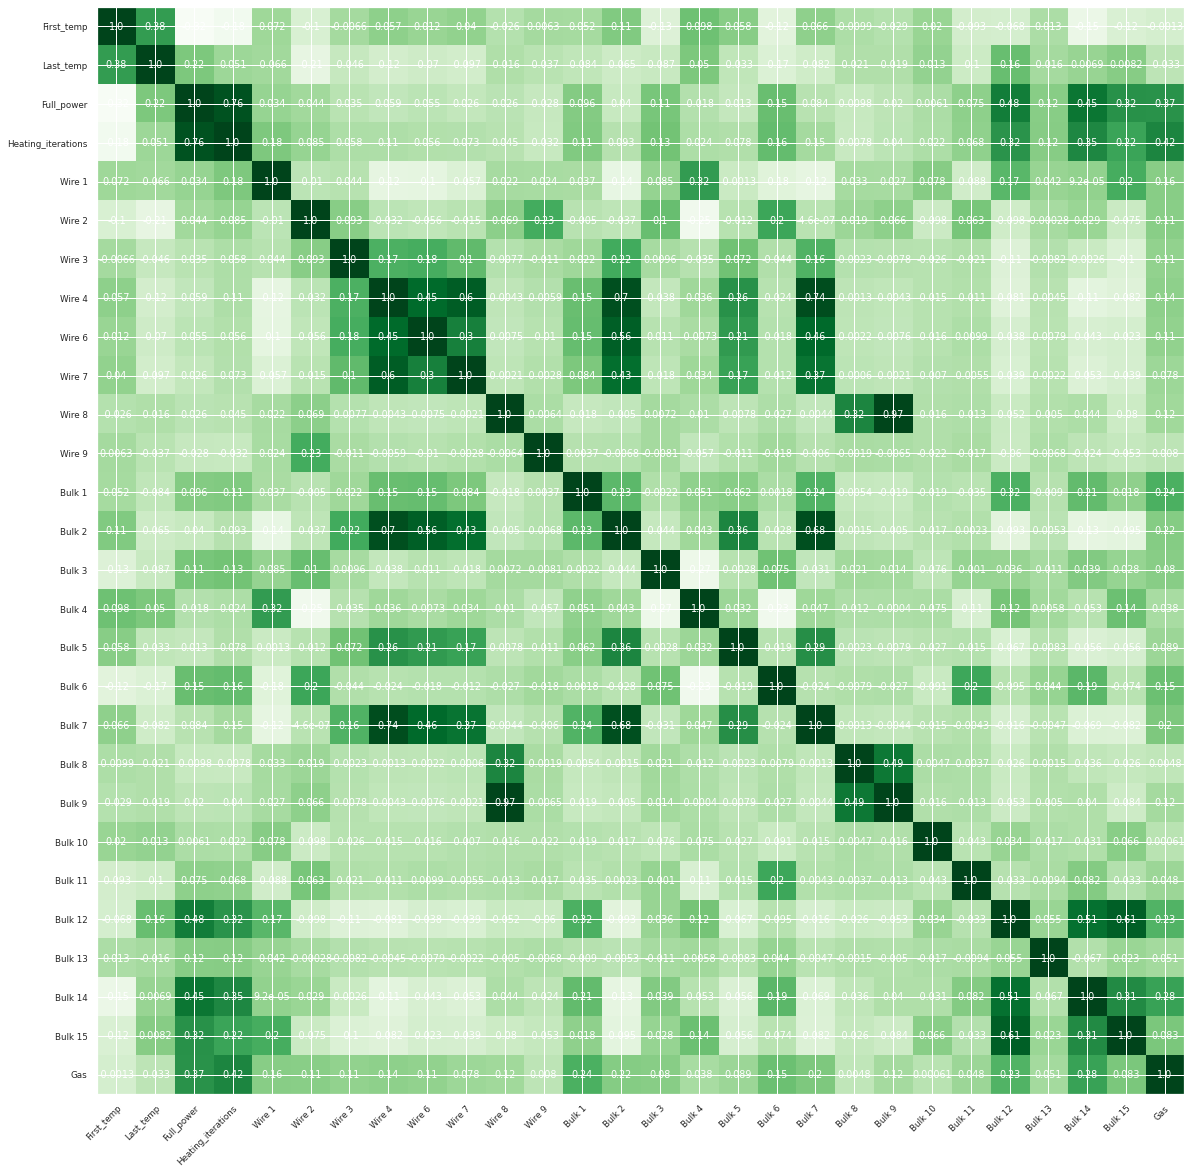

In [ ]:
data_corr = data.copy()
data_corr_multi = data_corr.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(data_corr_multi.index)))
ax.set_yticks(np.arange(len(data_corr_multi.index)))

ax.set_xticklabels(data_corr_multi.index)
ax.set_yticklabels(data_corr_multi.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

dataframe = data_corr_multi.values

for i in range(len(data_corr_multi.index)):
    for j in range(len(data_corr_multi.index)):
        text = ax.text(j, i, '{:.2}'.format(dataframe[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(data_corr_multi.corr(), cmap='Greens')

Сильно зависящих полей  не много (почти нет)

Разделим данные на тестовый и тренировочный сет

In [ ]:
train, test = train_test_split(data, test_size = .30, random_state = 42)

Что бы разброс в полях с количественными признаками не сказался на обучении – проведём масштабирование

In [ ]:
numeric = data.columns.tolist()
numeric = [i for i in numeric if i not in ('Last_temp')]
scaler = MinMaxScaler()
scaler.fit(train[numeric])

test[numeric] = scaler.transform(test[numeric])

train[numeric] = scaler.transform(train[numeric])

In [ ]:

print('Размер тренировочной:', train.shape)
print('Размер тестовой:', test.shape)

Размер тренировочной: (1732, 28)
Размер тестовой: (743, 28)


Вывод по шагу

- Мы свели признаки в итоговую таблицу
- Разбили датафрейм на тестовую и тренировочную выборки в соотношении 30/70
- Использовали масштабирование признаков
- Посмотрели на мультиколинеарность
- Сделали предобработку
- Избавились пустых значений

# Шаг модели

Отделим целевой признак на обучающей и тестовой

In [ ]:
features_train = train.drop(['Last_temp'], axis = 1)
target_train = train['Last_temp']

features_test = test.drop(['Last_temp'], axis = 1)
target_test = test['Last_temp']

Описание моделей и параметров

In [ ]:
models = {
    'CatBoostRegressor': CatBoostRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor(),
    'XGBRegressor': xgboost.XGBRegressor(),
    'LinearRegression': LinearRegression()
}


params = {
    'CatBoostRegressor':{
          'loss_function':['MAE'],
          'n_estimators': np.arange(300, 700, 100),  
          'learning_rate': np.arange(0.03, 0.12, 0.02),
          'random_state':[17],
          'depth': np.arange(3, 7)
    },        

    'LinearRegression':{
            'fit_intercept' : [True, False],
            'normalize':[True,False]
    },
    
    
    'LGBMRegressor': {
        'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
        'objective': ['regression'],
        'learning_rate': [0.001, 0.01, 0.02, 0.03],
        'num_iterations':[500],
        'random_state': [42], 
        'max_depth': np.arange(2, 10),
        'metric': ['mae']
        },

    
    'XGBRegressor': {
        'min_child_weight': [10,20,30],
        'gamma': [5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5,10,20],
        'eval_metric' :['mae']
        }
}

Напишем функцию для запуска обучения

In [ ]:
def fit(train_features, train_actuals):
    for name in models.keys():
        est = models[name]
        est_params = params[name]
        gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5)
        gscv.fit(train_features, train_actuals)
        train_predictions = gscv.predict(features_train)
        predictions = gscv.predict(features_test)
        result_list.append({
        'model': name,
        'train_mae_score': mean_absolute_error(target_train, train_predictions),
        'test_mae_score': mean_absolute_error(target_test, predictions),
        'best_params': gscv.best_params_
        })

In [ ]:
%%time
result_list = []
fit(features_train, target_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
148:	learn: 4.0480283	total: 561ms	remaining: 1.32s
149:	learn: 4.0388605	total: 564ms	remaining: 1.31s
150:	learn: 4.0297247	total: 567ms	remaining: 1.31s
151:	learn: 4.0215028	total: 571ms	remaining: 1.31s
152:	learn: 4.0165457	total: 574ms	remaining: 1.3s
153:	learn: 4.0104871	total: 578ms	remaining: 1.3s
154:	learn: 4.0007377	total: 581ms	remaining: 1.29s
155:	learn: 3.9957462	total: 584ms	remaining: 1.29s
156:	learn: 3.9904951	total: 588ms	remaining: 1.28s
157:	learn: 3.9804540	total: 591ms	remaining: 1.28s
158:	learn: 3.9733948	total: 595ms	remaining: 1.27s
159:	learn: 3.9698753	total: 599ms	remaining: 1.27s
160:	learn: 3.9656366	total: 605ms	remaining: 1.27s
161:	learn: 3.9621665	total: 612ms	remaining: 1.28s
162:	learn: 3.9510384	total: 616ms	remaining: 1.27s
163:	learn: 3.9396114	total: 619ms	remaining: 1.27s
164:	learn: 3.9331772	total: 623ms	remaining: 1.26s
165:	learn: 3.9263553	total: 626ms	remaining: 1.26

Посмотрим на лучшие параметры

In [ ]:
results = pd.DataFrame(result_list, columns=['model','train_mae_score','test_mae_score','best_params'])
results.set_index("model", inplace = True)
results

,train_mae_score,test_mae_score,best_params
model,,,
CatBoostRegressor,4.749680,5.970665,"{'depth': 3, 'learning_rate': 0.07, 'loss_func..."
LGBMRegressor,4.910220,6.065231,"{'boosting_type': 'gbdt', 'learning_rate': 0.0..."
XGBRegressor,3.605706,6.065604,"{'colsample_bytree': 1.0, 'eval_metric': 'mae'..."
LinearRegression,7.925578,7.895936,"{'fit_intercept': True, 'normalize': False}"


Сравнение MAE тестовой и тренировочной

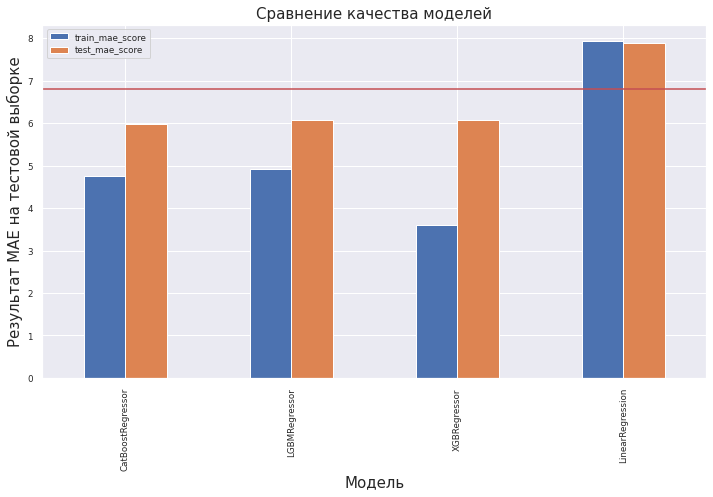

In [ ]:
plt.figure(figsize=(10, 7))
plt.subplot(111)
results.plot(kind='bar', ax=plt.gca()).hlines(6.8, -1, 5, color = 'r')
plt.xlabel('Модель', fontsize=15)
plt.ylabel('Результат MAE на тестовой выборке', fontsize=15)
plt.title('Сравнение качества моделей', fontsize=15)
plt.tight_layout()

Вывод:

- Провели подбор параметров к 4м моделям CatBoost, LightGBM, XGboost и LinearRegression
- Наилучшие результаты получили у CatBoost с результатом 5.8 на тестовой выборке
У LightGBM и XGBoost по ~6 MAE на тестовой выборке. Хуже всего показала результат модель LinearRegression с результатом 7.8 на тестовой выборке

CatBoost на тестовой выборке с наилучшими параметрами

In [ ]:
model = CatBoostRegressor(depth=4, 
                          learning_rate = 0.11000000000000001, 
                          loss_function = 'MAE', 
                          n_estimators = 600, 
                          random_state = 17,
                          verbose = 0)

model.fit(features_train,target_train)
predictions = model.predict(features_test)
print('MAE на тестовой выборке:', mean_absolute_error(predictions,target_test))

MAE на тестовой выборке: 5.999827574101409


Feature Importance

In [ ]:
def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

График feature importance

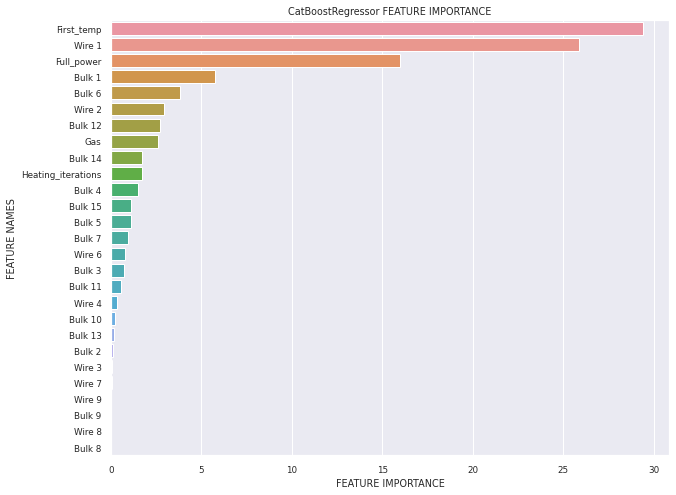

In [ ]:
plot_feature_importance(model.feature_importances_,features_test.columns,'CatBoostRegressor ')

Финальная проверка модели получила результат MAE 5.9 на тестовой выборке, что вполне приемлемо.

# Итоговый вывод

Все этапы проекты выполнены, а именно:

- Начальный шаг.
- Шаг предобработки
- Шаг подготовки
- Шаг модели
- Итоговый вывод

Основные трудности с которыми пришлось столкнуться, это подготовка и группировка данных в одну таблицу, в частности – подготовка признаков. Так как значительную часть партий мы не приняли из-за отсутствия целевого значения в них.

Ключевые шаги в решении задачи:
- Был произведён первый взгляд на данные и их загрузка. Средствами библиотеки пандас и применением функций в том числе составленных самостоятельно.
- Анализ статистики датафреймов. Через визуализацию и изучение распределения значений таблицы, обозначили отсутствующие значения температуры в некоторых партиях, аномальные значения мощности, отсутствующие партии. Попытались дать объяснение, почему так происходит. 
- Изменены типы данных и удалены партии с пропущеными значениями в температуре.
- Адекватно прошла подготовка признаков и выделение целевого (финальной температуры).  В том числе был добавлен новый признак - полная мощность и проверена мультиколинеарность.
- Составлена общая таблица для обучения модели.
- Выбраны и обучены регрессионные модели: CatBoostRegressor,LGBMRegressor, XGBRegressor, LinearRegression
- Найдена модель и её лучшие параметры
- Модель проверена на тестовой выборке и получен MAE
- Построен график feature importance по итогам которого выяснилось что наиболее важным фактором является первоначальное измерение температуры расплава

Лучшей моделью стала CatBoost с оптимальными параметрами. MAE составил 5.9. Это значит, что модель в целом может ошибаться на 5-6 градусов, что нас устраивает.


